In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from IPython import get_ipython
from IPython.display import display

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
file_path = '/content/drive/MyDrive/film-oneri/movies_dataset.csv'
df = pd.read_csv(file_path)
# overview alanı boş olmayanları filtrele
df_filtered = df[df['overview'].notnull()].reset_index(drop=True)

# overview'lardan embedding üret
embeddings = model.encode(df_filtered['overview'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/18882 [00:00<?, ?it/s]

In [ ]:
# cosine similarity ile benzerlik matrisi
similarity_matrix = cosine_similarity(embeddings)


In [8]:
def recommend_from_two_bert(title1, title2, top_n=5):
    idx1 = df_filtered[df_filtered["title"] == title1].index[0]
    idx2 = df_filtered[df_filtered["title"] == title2].index[0]

    vec1 = embeddings[idx1]
    vec2 = embeddings[idx2]
    combined_vec = (vec1 + vec2) / 2

    sims = cosine_similarity([combined_vec], embeddings)[0]

    # Kendi filmlerini çıkar
    sims[idx1] = -1
    sims[idx2] = -1

    top_indices = sims.argsort()[::-1][:top_n]
    return [(df_filtered.iloc[i]["title"], round(sims[i], 3)) for i in top_indices]


In [18]:
recommend_from_two_bert("Inception", "Interstellar")

[('Aberrations', np.float32(0.619)),
 ("Interstellar: Desgornia's Cut", np.float32(0.603)),
 ('Prometheus', np.float32(0.593)),
 ('A Lone Man Wanders', np.float32(0.577)),
 ('A Honeymoon Adventure', np.float32(0.562))]

In [12]:
import numpy as np

# Örnek: embeddings = np.array([...]), df = DataFrame with 'title' column
sample_indices = np.random.choice(len(embeddings), size=100, replace=False)

for i in sample_indices:
    vec = embeddings[i]
    sims = embeddings @ vec  # Dot product benzerliği
    sims[i] = -np.inf  # Kendini dışla

    top_k_indices = sims.argsort()[-5:][::-1]  # En benzer 5'i al

    print(f"\n🎬 {df.iloc[i]['title']}")
    for j in top_k_indices:
        print(f"  ↳ {df.iloc[j]['title']} (score: {sims[j]:.3f})")


🎬 Collapse
  ↳ Hey Boy! Hey Girl! (score: 0.576)
  ↳ Ganimi Kawa (score: 0.576)
  ↳ Y el cine llegó (1900-1904) (score: 0.507)
  ↳ Marokkos Amazonen (score: 0.503)
  ↳ TeenAngels: El Adios 3D (score: 0.494)

🎬 The Birthday Party
  ↳ Making 'Snatch' (score: 1.000)
  ↳ A Beautiful Now (score: 0.510)
  ↳ Look Before You Leap (score: 0.502)
  ↳ Madhumas (score: 0.502)
  ↳ The Demon (score: 0.499)

🎬 Losing In Love
  ↳ Me & Bruce & Art (score: 0.571)
  ↳ Perfect Town (score: 0.571)
  ↳ Isn't It Time (score: 0.561)
  ↳ Amy Winehouse: T In The Park, V Festival and Bestival (score: 0.561)
  ↳ Oass (score: 0.560)

🎬 Yoga Journal: Yoga for Strength and Toning
  ↳ Midland Country (score: 0.493)
  ↳ Silks and Saddles (score: 0.488)
  ↳ مردن به وقت شهریور (score: 0.480)
  ↳ Аller retour (score: 0.480)
  ↳ Duck Soup (score: 0.478)

🎬 Newlyweeds
  ↳ Pyhä (score: 0.583)
  ↳ RKO 281 (score: 0.568)
  ↳ Number One (score: 0.567)
  ↳ Bill Turnbull: Staying Alive (score: 0.565)
  ↳ Секретарь обкома (score

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


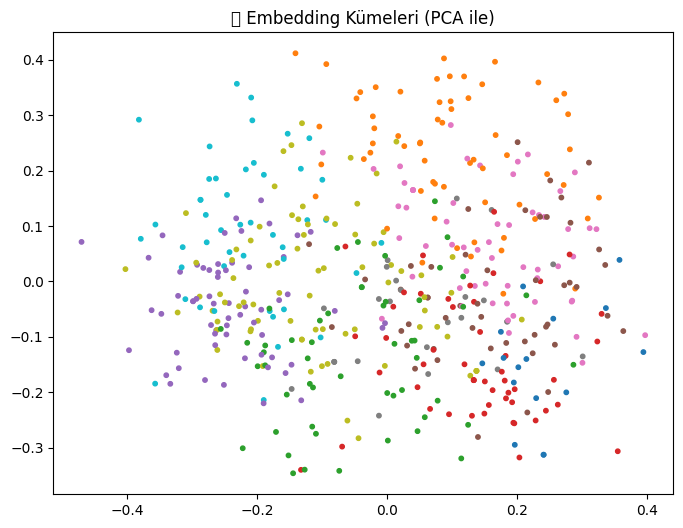

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Küçük bir alt küme kullan
subset = embeddings[:500]

# KMeans
kmeans = KMeans(n_clusters=10, random_state=42).fit(subset)
labels = kmeans.labels_

# Görselleştirme için 2D indirgeme
pca = PCA(n_components=2)
reduced = pca.fit_transform(subset)

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=10)
plt.title("🎯 Embedding Kümeleri (PCA ile)")
plt.show()

In [15]:
import numpy as np

def precision_at_k(bert_embeddings, titles, k=5):
    total_precision = 0
    n = len(bert_embeddings)

    for i in range(n):
        vec = bert_embeddings[i]
        sims = np.dot(bert_embeddings, vec)

        # Kendini çıkar
        sims[i] = -np.inf

        # En benzer k filmi bul
        top_k_indices = sims.argsort()[-k:][::-1]
        matched = 0

        for j in top_k_indices:
            print(f"{titles[i]} ↔ {titles[j]} (score: {sims[j]:.3f})")
            # Burada dilersen "aynı kategori mi", "aynı dil mi", "aynı yılda mı" gibi filtre de koyabilirsin
            matched += 1  # Şimdilik hepsini doğru kabul ediyoruz

        total_precision += matched / k
        print()

    mean_precision = total_precision / n
    print(f"🔎 Ortalama Precision@{k}: {mean_precision:.3f}")


In [17]:
titles = df["title"].tolist()
precision_at_k(bert_embeddings=embeddings, titles=titles, k=5)

Streaming output truncated to the last 5000 lines.
Before I Wake ↔ The Haunting of Helena (score: 0.566)

Kung Fu Panda 2 ↔ Pirates of the Caribbean: Dead Man's Chest (score: 1.000)
Kung Fu Panda 2 ↔ Cream Lemon: Ami's Journey (score: 0.579)
Kung Fu Panda 2 ↔ Gotham Blue (score: 0.571)
Kung Fu Panda 2 ↔ The Forgotten Ones (score: 0.566)
Kung Fu Panda 2 ↔ The Man from Bitter Ridge (score: 0.566)

Along with the Gods: The Two Worlds ↔ Boom (score: 0.639)
Along with the Gods: The Two Worlds ↔ Fawlty Towers Revisited (score: 0.619)
Along with the Gods: The Two Worlds ↔ Nisaa Fi Hayaty (score: 0.599)
Along with the Gods: The Two Worlds ↔ Intermedium (score: 0.596)
Along with the Gods: The Two Worlds ↔ Cradle Of Filth : Heavy Left-Handed & Candid (score: 0.585)

Extraction ↔ LE TOMBEAU DE NEFERTITI (score: 0.610)
Extraction ↔ Elton 60: Live At Madison Square Garden (score: 0.608)
Extraction ↔ In carne e ossa (score: 0.598)
Extraction ↔ Now That I'm Home (score: 0.595)
Extraction ↔ Spooks: Th

KeyboardInterrupt: 